In [1]:
%matplotlib inline
from IPython.display import clear_output
import os

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

from models import ConvNet
from helper import ExperimentLogger, display_train_stats
from fl_devices import Server, Client
from data_utils import split_noniid, CustomSubset


torch.manual_seed(42)
np.random.seed(42)

In [2]:
data = datasets.EMNIST(root=".", split="byclass", download=True)

mapp = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C',
       'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
       'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c',
       'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p',
       'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'], dtype='<U1')

idcs = np.random.permutation(len(data))
train_idcs, test_idcs = idcs[:10000], idcs[10000:20000]
train_labels = data.train_labels.numpy()

client_idcs = split_noniid(train_idcs, train_labels, alpha=100.0, n_clients=10)

client_data = [CustomSubset(data, idcs) for idcs in client_idcs]
test_data = CustomSubset(data, test_idcs, transforms.Compose([transforms.ToTensor()]))


for i, client_datum in enumerate(client_data):
    if i>=5:
        client_datum.subset_transform = transforms.Compose([transforms.RandomRotation((180,180)),
                                                      transforms.ToTensor()])
    else:
        client_datum.subset_transform = transforms.Compose([transforms.ToTensor()])

/home/sattler/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


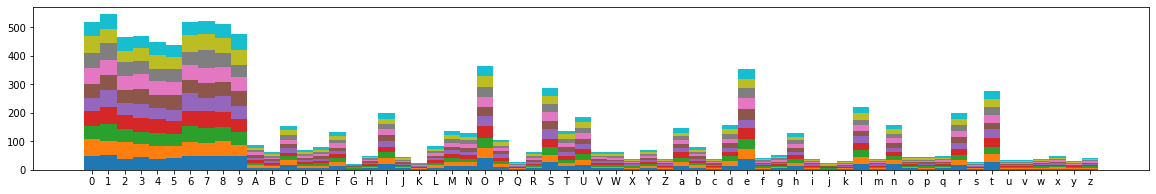

In [3]:
plt.figure(figsize=(20,3))
plt.hist([train_labels[idc]for idc in client_idcs], stacked=True, bins=np.arange(min(train_labels)-0.5, max(train_labels) + 1.5, 1))
plt.xticks(np.arange(62), mapp)
plt.show()

In [4]:
clients = [Client(ConvNet, lambda x : torch.optim.SGD(x, lr=0.1, momentum=0.9), dat, idnum=i) 
           for i, dat in enumerate(client_data)]
server = Server(ConvNet, test_data)

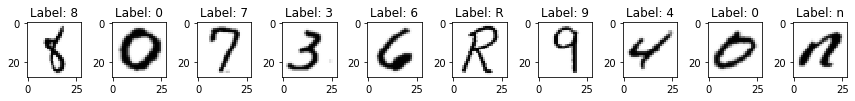

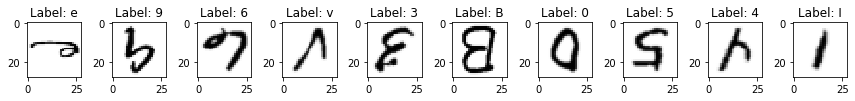

In [5]:
for client in [clients[0], clients[5]]:
    x, y = iter(client.train_loader).next()

    plt.figure(figsize=(15,1))
    for i in range(10):
        plt.subplot(1,10,i+1)
        plt.imshow(x[i,0].numpy().T, cmap="Greys")
        plt.title("Label: {}".format(mapp[y[i].item()]))
    plt.show()

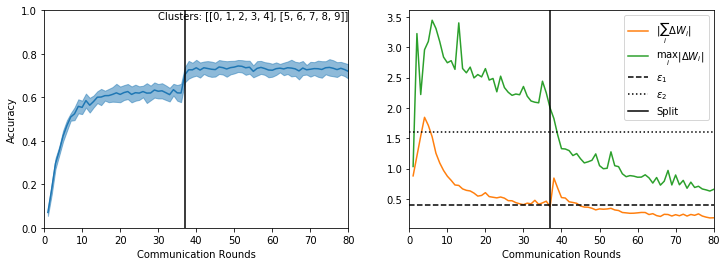

In [6]:
COMMUNICATION_ROUNDS = 80
EPS_1 = 0.4
EPS_2 = 1.6
    
    
cfl_stats = ExperimentLogger()
    
idccs = [np.arange(len(clients)).astype("int")]
client_clusters = [[clients[i] for i in idcs] for idcs in idccs]


for c_round in range(1, COMMUNICATION_ROUNDS+1):

    if c_round == 1:
        for client in clients:
            client.synchronize_with_server(server)
            
    participating_clients = server.select_clients(clients, frac=1.0)

    for client in participating_clients:
        train_stats = client.compute_weight_update(epochs=1)
        client.reset()

    similarities = server.compute_pairwise_similarities(clients)

    idccs_new = []
    for idc in idccs:
        max_norm = server.compute_max_update_norm([clients[i] for i in idc])
        mean_norm = server.compute_mean_update_norm([clients[i] for i in idc])
             
        if mean_norm<EPS_1 and max_norm>EPS_2 and len(idc)>2 and c_round>20:
            c1, c2 = server.cluster_clients(similarities[idc][:,idc]) 
            idccs_new += [c1, c2]
             
            cfl_stats.log({"split" : c_round})

        else:
            idccs_new += [idc]
        
        
    idccs = idccs_new
    client_clusters = [[clients[i] for i in idcs] for idcs in idccs]

    server.aggregate_clusterwise(client_clusters)

    acc_clients = [client.evaluate() for client in clients]
    
    cfl_stats.log({"acc_clients" : acc_clients, "mean_norm" : mean_norm, "max_norm" : max_norm,
                  "rounds" : c_round, "clusters" : idccs})
    
    
    display_train_stats(cfl_stats, EPS_1, EPS_2, COMMUNICATION_ROUNDS)
